> ### EEE4423: Signal Processing Lab

# LAB \#10: Image Style Transfer

<h4><div style="text-align: right"> Due date:  </div> <br>
<div style="text-align: right"> Please upload your file @ yscec by 9 PM in the form of [ID_Name_Lab10.ipynb]. </div></h4>

### *Instructions:*
- Write a program implementing a particular algorithm to solve a given problem.   
- <span style="color:red">**Report and discuss your results. Analyze the algorithm, theoretically and empirically.**</span> 
- Each team must write their own answers and codes (<span style="color:red">**if not you will get a F grade**</span>).

<h2><span style="color:blue">2014142243 차현수</span> </h2>

In [1]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2021-10-15 00:59:21.785227




# Neural Stylization with Pytorch
## Introduction


<img src="http://drive.google.com/uc?export=view&id=1crqAv5aoJ3uMSDFT99l6VuzY3VUlF_C7" alt="no_image" style="width: 900px;"/>


This lab introduces a Neural Algorithm of Artistic Style that can separate and recombine the image content and style of natural images. The algorithm takes two images, a content-image, and a style-image, and generates the optimized image to resemble the content of the content-image and the artistic style of the style-image.


**Main idea**

To transfer the style image $\textit{I}_s$ onto a content image $\textit{I}_c$ we synthesize a new image that simultaneously matches the content representation of $\textit{I}_c$ and the style representation of $\textit{I}_s$ (Fig). Thus we jointly minimize the distance of the feature representations of a white noise image from the content representation of the photograph in one layer and the style representation of the painting defined on a number of layers of the Convolutional Neural Network.
<img src="http://drive.google.com/uc?export=view&id=1BhfqqQEMn3AyHpc6fB-shQDlU-tQeoLz" alt="no_image" style="width: 900px;"/>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

from PIL import Image
import numpy as np

from torchvision import datasets
from torch.utils.data import DataLoader


**Style and content image**

In [3]:
style_img_name = "dataset/lab10/style/mosaic.jpg"
content_img_name = "dataset/lab10/content/Tuebingen_Neckarfront.jpg"

In [4]:
style_img = Image.open(style_img_name)
content_img = Image.open(content_img_name)

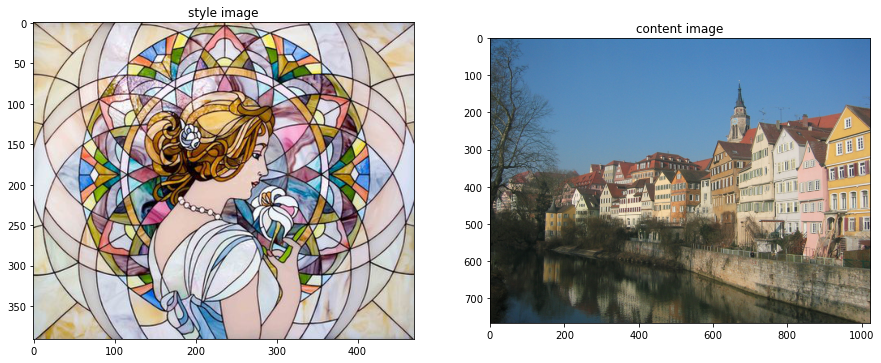

In [5]:
plt.figure(figsize = (15,15))
plt.subplot(1,2,1)
plt.title('style image')
plt.imshow(style_img)
plt.subplot(1,2,2)
plt.title('content image')
plt.imshow(content_img)

### Style representation

To obtain a representation of the style of an input image, we use a feature space designed to capture texture information. This feature space can be built on top of the filter responses in any layer of the network. It consists of the correlations between the different filter responses, where the expectation is taken over the spatial extent of the feature maps. These feature correlations are given by the Gram matrix $\mathit{G} \in \mathcal{R}^{\mathit{N_l}  \times  \mathit{N_l}}$, where $\mathit{G^l_{ij}}$ is the inner product between the vectorised feature maps $i$ and $j$ in layer $l$:

### <center> ${\mathit{G^l_{ij}} = \sum_{k}{F^l_{ik}F^l_{jk}}}$ </center>

In [6]:
def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram

### Deep image representations

In this work we show how the generic feature representations learned by high-performing Convolutional Neural Networks can be used to independently process and manipulate the content and the style of natural images.

The image reperesentations were generated on the basis of the VGG network, which was trained to perform object recognition and localization. We use the feature space provided by the 16 convolutional and 5 pooling layers of the 19-layer VGG network.

In [7]:
import torchvision.models.vgg as vgg

class LossNetwork(torch.nn.Module):
    def __init__(self):
        super(LossNetwork, self).__init__()
        # get vgg network
        self.vgg_layers = vgg.vgg19(pretrained=True).features


    def forward(self, x, layer_name):
        output = {}
        for name, module in self.vgg_layers._modules.items():
            x = module(x)
            if name in layer_name:
                output[layer_name[name]] = x
        return output

In [8]:
loss_net = LossNetwork().cuda()
for param in loss_net.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/stephencha/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Content representation is on layer ‘conv4 2’ and the style representation is on layers ‘conv1 1’, ‘conv2 1’, ‘conv3 1’, ‘conv4 1’ and ‘conv5 1’

In [9]:
style_layer_name = {
    '1': "conv1-1",
    '6': "conv2-1",
    '11': "conv3-1",
    '20': "conv4-1",
    '29': "conv5-1"
}

content_layer_name = {
    '22': "conv4-2"
}

**Pre and post processing for images**

In [10]:

img_size = 512 
prep = transforms.Compose([transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
                        std=[1,1,1]),
])

post = transforms.Compose([
    transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], #add imagenet mean
                        std=[1,1,1]),
    transforms.Lambda(lambda x: torch.clamp(x,0,1)),
    transforms.ToPILImage()
])

In [11]:
content = prep(content_img).cuda().unsqueeze(0)
style = prep(style_img).cuda().unsqueeze(0)

out_img = content.clone()
out_img.requires_grad = True


criterion = nn.MSELoss()
style_gt = [gram_matrix(f).detach() for f in loss_net(style, style_layer_name).values()]
content_gt = [A.detach() for A in loss_net(content, content_layer_name).values()]

show_iter = 50
optimizer = optim.LBFGS([out_img])
n_iter = [0]

**Hyper parameters**

In [12]:
alpha = 1e0
beta = 1e7
max_iter = 500

**Optimizing image**

In [13]:
while n_iter[0] <= max_iter:

    def closure():
        optimizer.zero_grad()
        
        style_layers = [gram_matrix(f) for f in loss_net(out_img, style_layer_name).values()]
        content_layers = [f for f in loss_net(out_img, content_layer_name).values()]
        
        style_loss = 0
        for i in range(len(style_layers)):    
            style_loss += criterion(style_layers[i], style_gt[i])
        
        content_loss = criterion(content_layers[0], content_gt[0])
        
        loss = alpha * content_loss + beta * style_loss
        loss.backward()
        n_iter[0]+=1
        #print loss
        if n_iter[0]%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.item()))

        return loss

    optimizer.step(closure)
    
#display result

Iteration: 50, loss: 8.880418
Iteration: 100, loss: 6.384209
Iteration: 150, loss: 5.708985
Iteration: 200, loss: 5.370107
Iteration: 250, loss: 5.166139
Iteration: 300, loss: 5.036379
Iteration: 350, loss: 4.945747
Iteration: 400, loss: 4.878028
Iteration: 450, loss: 4.826740
Iteration: 500, loss: 4.786677


**Visualize result images**

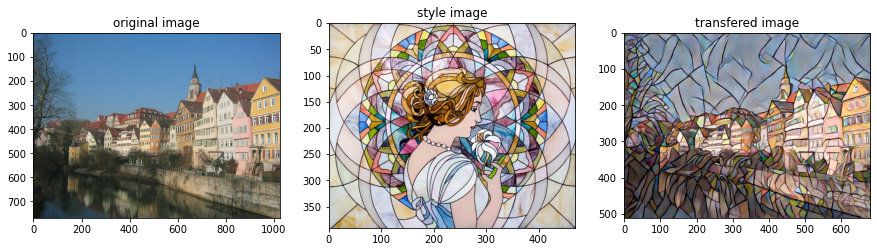

In [14]:
out_img_hr = post(out_img.data[0].cpu().squeeze())

plt.figure(figsize = (15,15))

plt.subplot(1,3,1)
plt.title('original image')
plt.imshow(content_img)
plt.subplot(1,3,2)
plt.title('style image')
plt.imshow(style_img)
plt.subplot(1,3,3)
plt.title('transfered image')
plt.imshow(out_img_hr)
plt.show()



# Perceptual Losses for Style Transfer with Pytorch


**Main idea**

Previous method produces high-quality results, but is computationally expensive since each step of the optimization problem requires a forward and backward pass through the pretrained network. To overcome this computational burden, we train a feed-forward network to quickly approximate solutions to their optimization problem.
<img src="http://drive.google.com/uc?export=view&id=1GFM9l-63SsOFYHP-g2WNN2T6zNDdD09Z" alt="no_image" style="width: 900px;"/>


$\mathcal{L}_{total} = \alpha\sum_{}{\mathcal{l}_{content}} + \beta\sum_{}{\mathcal{l}_{style}} + \gamma\mathcal{l}_{TV}$

- $\mathcal{l}_{content}^{\phi,j} = ||\phi_j(\hat{y}) - \phi_j(y)||^2_2$, $\phi$ represents vgg feature

- $\mathcal{l}_{style}^{\phi,j} = ||G^{\phi}_{j}(\hat{y}) - G^{\phi}_{j}(y)||^2_F$, $G$ represents gram matrix.

- $\mathcal{l}_{TV}(y) = \sum_{i,j}{|y_{i+1,j}-y_{i,j}|+|y_{i,j+1}-y_{i,j}|}$



**Data loader**

In [15]:
data_root = "dataset/lab10/train"
image_size = 224
transform = transforms.Compose([
    transforms.Resize(image_size), 
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])])

train_dataset = datasets.ImageFolder(data_root, transform)

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

### 1.1 Write code (Image Transform Net) [3 points]

<img src="http://drive.google.com/uc?export=view&id=1OQzOwfRgpncvvBCwUCJbShYQGBElUqjW" alt="no_image" style="width: 400px;"/>

##### Residual block (channel, x)
- Conv 1: $3\times3$ Conv(in: channel, out: channel, padding: 1) with reflection padding
- Instance Norm
- Relu
- Conv 2: $3\times3$ Conv(in: channel, out: channel, padding: 1) with reflection padding
- Instance Norm
- Residual Connection

#### ImageTransformNet
- Conv $9\times9$  (in: 3, out: 32, padding: 4) with reflection padding
- Instance Norm
- Relu
- Conv $3\times3$  (in: 32, out: 64, padding: 1, **stride: 2**) with reflection padding
- Instance Norm
- Relu
- Conv $3\times3$  (in: 64, out:128, padding: 1, **stride: 2**) with reflection padding
- Instance Norm
- Relu
- 5 Residual block(channel: 128)
- $2\times$ Nearest Upsample
- Conv $3\times3$  (in: 128, out:64, padding: 1) with reflection padding
- Instance Norm
- Relu
- **$2\times$ Nearest Upsample**
- Conv $3\times3$  (in: 64, out:32, padding: 1) with reflection padding
- Instance Norm
- Relu
- Conv $9\times9$  (in: 32, out:3, padding: 4) with reflection padding



In [16]:
class Residual_block(torch.nn.Module):
    def __init__(self, channel):
        super(Residual_block, self).__init__()
        self.residual = nn.Sequential(
            # There are padding_mode in conv2d layers
            nn.Conv2d(in_channels=channel, out_channels=channel, padding=1, kernel_size=3, padding_mode='reflect'),
            nn.InstanceNorm2d(num_features=channel, affine=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=channel, out_channels=channel, padding=1, kernel_size=3, padding_mode='reflect'),
            nn.InstanceNorm2d(num_features=channel, affine=True),
        )
        
    def forward(self, x):
        # Residual connection
        out = self.residual(x) + x
        return out

In [17]:
class basic_block(torch.nn.Module):
    # For ease of implementation of ImageTransformNet, basic blocks are created for similar structure layers.
    def __init__(self, in_c, out_c, padding, kernel_size, stride=1):
        super(basic_block, self).__init__()
        self.basic = nn.Sequential(
            nn.Conv2d(in_channels=in_c, out_channels=out_c, padding=padding, kernel_size=kernel_size, stride=stride, padding_mode='reflect'),
            nn.InstanceNorm2d(num_features=out_c, affine=True),
            nn.ReLU(),
        )
    def forward(self, x):
        x = self.basic(x)
        return x

In [18]:
class ImageTransformNet(torch.nn.Module):
    def __init__(self):
        super(ImageTransformNet, self).__init__()
        #############
        # CODE HERE #
        self.net = nn.Sequential(
            basic_block(in_c=3, out_c=32, padding=4, kernel_size=9),
            basic_block(in_c=32, out_c=64, padding=1, stride=2, kernel_size=3),
            basic_block(in_c=64, out_c=128, padding=1, stride=2, kernel_size=3),
            Residual_block(channel=128),
            Residual_block(channel=128),
            Residual_block(channel=128),
            Residual_block(channel=128),
            Residual_block(channel=128),
            # 2x upscaling with nearest mode.
            nn.Upsample(scale_factor=2, mode='nearest'),
            basic_block(in_c=128, out_c=64, padding=1, kernel_size=3),
            nn.Upsample(scale_factor=2, mode='nearest'),
            basic_block(in_c=64, out_c=32, padding=1, kernel_size=3),
            nn.Conv2d(in_channels=32, out_channels=3, padding=4, kernel_size=9, padding_mode='reflect')
        )
        #############

    def forward(self, X):
        #############
        # CODE HERE #
        out = self.net(X)
        return out
        #############


In [19]:
transformer = ImageTransformNet().cuda()

### 1.2 Find style and content representation layers in loss net [1 points]

In [20]:
style_layer_name = {
    #############
    # CODE HERE #
    '3': "relu1-2",
    '8': "relu2-2",
    '15': "relu3-3",
    '24': "relu4-3"
    #############
}

content_layer_name = {
    #############
    # CODE HERE #
    '15': "relu3-3"
    #############
}

In [21]:
style = transform(style_img).cuda().unsqueeze(0) # Image Normalization
style_gt = [gram_matrix(f).detach() for f in loss_net(style, style_layer_name).values()]

**Hyper parameters**

In [22]:
# You may adjust hyper paramters 
alpha_list = [1e0, 1e1] # Content weight
beta_list = [1e5, 1e7] # Style weight
gamma_list = [1e-7, 1e-9] # TV weight

# It can change the values for style image.
alpha = alpha_list[0]
beta = beta_list[0]
gamma = gamma_list[0]

print('Parameter is alpha: ', alpha, 
      ', beta: ', beta, 
      ', gamma: ', gamma)

LR = 1e-3
steps = 2000
optimizer = optim.Adam(transformer.parameters(), LR)

Parameter is alpha:  1.0 , beta:  100000.0 , gamma:  1e-07


### 1.3 Train the image transformNet [4 points]

- Print total loss, content loss, style loss and total variation loss for every 50 iterations
- Style loss should contain all of the layers listed above
- Use alpha, beta, gamma as coefficient

In [23]:
transformer.train()
n_iter = 0
class Found(Exception): pass
try:
    while True:
        for x, _ in train_loader:
            #############
            # CODE HERE #
            optimizer.zero_grad()
            
            x = x.cuda()
            y_h = transformer(x)
            
            # Get Style Loss
            y_h_style_feat = [gram_matrix(f) for f in loss_net(y_h, style_layer_name).values()]
            style_loss = 0
            for i in range(len(style_gt)):    
                style_loss += criterion(y_h_style_feat[i], style_gt[i])
            
            # Get Content Loss
            content = x
            # Image Normalization
            content_gt = [A.detach() for A in loss_net(content, content_layer_name).values()]
            y_h_content_feat = [A for A in loss_net(y_h, content_layer_name).values()]
            content_loss = criterion(y_h_content_feat[0], content_gt[0])
            
            # Get TV Loss
            first_term = torch.sum(torch.abs(y_h[:, :, :, 1:] - y_h[:, :, :, :-1]))
            second_term = torch.sum(torch.abs(y_h[:, :, 1:, :] - y_h[:, :, :-1, :]))
            TV_loss = first_term + second_term
            
            # Get Total Loss
            loss = alpha * content_loss + beta * style_loss + gamma * TV_loss
            loss.backward()
            
            n_iter += 1
            
            if n_iter % 50 == 0:
                print('Iteration: %d, loss: %f, content loss: %f, style loss: %f, TV loss: %f'
                        %(n_iter, loss.item(), content_loss.item(), style_loss.item(), TV_loss.item()))

            optimizer.step()
            #############
            
            if n_iter >= steps:
                raise Found

except Found:
    pass

/usr/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 64, 64])) that is different to the input size (torch.Size([4, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 128, 128])) that is different to the input size (torch.Size([4, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 256, 256])) that is different to the input size (torch.Size([4, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure t

Iteration: 50, loss: 248.101593, content loss: 39.549606, style loss: 0.002085, TV loss: 278625.125000
Iteration: 100, loss: 120.253807, content loss: 49.102970, style loss: 0.000711, TV loss: 406293.625000
Iteration: 150, loss: 94.318520, content loss: 49.869732, style loss: 0.000444, TV loss: 455839.562500
Iteration: 200, loss: 87.099586, content loss: 49.312416, style loss: 0.000377, TV loss: 459972.218750
Iteration: 250, loss: 79.464729, content loss: 48.754139, style loss: 0.000307, TV loss: 460736.437500
Iteration: 300, loss: 74.885826, content loss: 50.479950, style loss: 0.000244, TV loss: 478222.000000
Iteration: 350, loss: 72.367424, content loss: 50.403812, style loss: 0.000219, TV loss: 478548.125000
Iteration: 400, loss: 73.477036, content loss: 48.141994, style loss: 0.000253, TV loss: 466669.312500
Iteration: 450, loss: 67.673729, content loss: 49.470840, style loss: 0.000182, TV loss: 490856.437500
Iteration: 500, loss: 68.359360, content loss: 45.214394, style loss: 0.

### 1.4 Discuss the result [2 points]
- Compare the result of neural style with yours
- Adjust the hyper parameter and analyze each result
- Use transform function before and after inference

torch.Size([1, 3, 768, 1024])


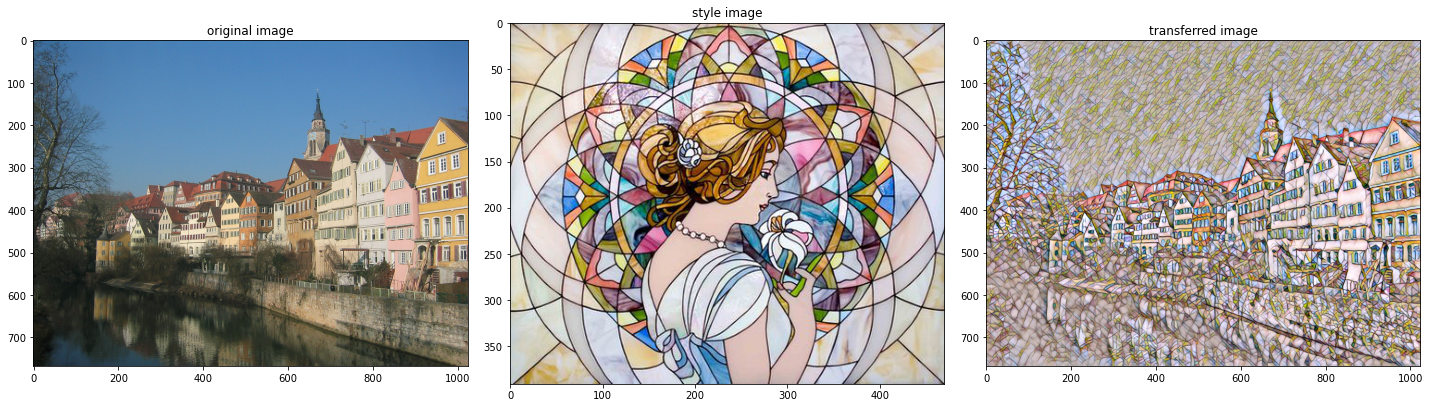

In [26]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])])

inverse_transform = transforms.Compose([
    transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
                         std=[1/0.229, 1/0.224, 1/0.255]),
    transforms.Lambda(lambda x: torch.clamp(x,0,1)),
    transforms.ToPILImage()
])

#############
# CODE HERE #
transformer.eval()
# Use transform function before and after inference.
temp = test_transform(content_img).cuda().unsqueeze(0)
result_img = transformer(temp)
print(result_img.size())
result_img_hr = inverse_transform(result_img.data[0].cpu().squeeze())
# Plot
plt.figure(figsize = (20,20))
plt.subplot(1,3,1)
plt.title('original image')
plt.imshow(content_img)
plt.subplot(1,3,2)
plt.title('style image')
plt.imshow(style_img)
plt.subplot(1,3,3)
plt.title('transferred image')
plt.imshow(result_img_hr)
# To restore the result image file to jpg for comparing my own result.
plt.tight_layout()
plt.savefig('result_img/1.jpg', bbox_inches='tight')

plt.show()
#############

# Result Report

##### 2014142243 차현수

The following experiments were repeated to find the values of the most appropriate parameters.

### Image 1
When alpha = 1e0, beta = 1e5, gamma = 1e-7
![1](result_img/1.jpg)

### Image 2
When alpha = 1e0, beta = 1e5, gamma = 1e-9
![2](result_img/2.jpg)

### Image 3
When alpha = 1e0, beta = 1e7, gamma = 1e-7
![3](result_img/3.jpg)

### Image 4
When alpha = 1e0, beta = 1e7, gamma = 1e-9
![4](result_img/4.jpg)

### Image 5
When alpha = 1e1, beta = 1e5, gamma = 1e-7
![5](result_img/5.jpg)

### Image 6
When alpha = 1e1, beta = 1e5, gamma = 1e-9
![6](result_img/6.jpg)

### Image 7
When alpha = 1e1, beta = 1e7, gamma = 1e-7
![7](result_img/7.jpg)

### Image 8
When alpha = 1e1, beta = 1e7, gamma = 1e-9
![8](result_img/8.jpg)

I observed how the picture changed by varying the value of the parameter. In conclusion, the most ideal experiments with style transfer are alpha=1e0, beta=1e5, and gamma=1e-7. One parameter at a time was observed to observe the change in the image with the change in each parameter. First, as the alpha value becomes larger, the content element becomes stronger, as can be observed through Image 1 and Image 5. That is, the style fades and the skeleton shape of the original image becomes stronger. Next, as shown by Image 1 and Image 3, the style becomes too strong. As a result, a picture that cannot be recognized through Image 3 is completed. Finally, as shown by Image 1 and Image 2, the overall hue of the image goes from red to blue. It is when gamma becomes larger that the color zone of visible light is skewed to dark.

The principles of the algorithm are described with annotations of each code. The difference between the first and second experiments is whether or not hat(y). With the addition of hat(y), the value of y that passed through ImageTransformNet, it was possible to implement faster operations and more accurate style transfer. The total value loss function is also introduced at a value of y, enabling styling that is more contrasted to the image's shading. TV Loss is significantly higher than other values, which forced Gamma to be set to a significantly lower value than alpha and beta. In addition, human beings seem to feel visually that the content's elements are stronger, making the frame of the image more neat, which makes them more likely to believe that research has succeeded. I personally think the first picture is better compared to the one in Image 1, but I think Image 1 is a better result in terms of speed and refinement.

### *References*
[1] Neural Transfer Pytorch Tutorial (https://pytorch.org/tutorials/advanced/neural_style_tutorial.html)